### 1. Import Libraries

In [132]:
import numpy as np

import pandas as pd

import sklearn
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import (
    OneHotEncoder,
    MinMaxScaler,
    PowerTransformer,
    FunctionTransformer,
    OrdinalEncoder,
    StandardScaler
)

from feature_engine.outliers import Winsorizer
from feature_engine.datetime import DatetimeFeatures
from feature_engine.selection import SelectBySingleFeaturePerformance
from feature_engine.encoding import (
    RareLabelEncoder,
    MeanEncoder,
    CountFrequencyEncoder
    )
import matplotlib.pyplot as plt

import warnings

### 2.Display Settings

In [133]:
pd.set_option('display.max_columns', None) # display all the columns

In [134]:
 # skicit transformer by default return numpy array, so if want output as dataframe below code will be done
sklearn.set_config(transform_output='pandas')

In [135]:
warnings.filterwarnings('ignore')

### 3. Read the Data

In [136]:
path = r'D:\CampusX\Flight_Sagemaker_Project\data\train.csv'

train = pd.read_csv(path)
train

,airline,date_of_journey,source,destination,dep_time,arrival_time,duration,total_stops,additional_info,price
0,Air India,2019-06-18,Banglore,Delhi,17:00:00,19:50:00,170,0.0,No Info,6961
1,Jet Airways,2019-04-24,Banglore,Delhi,08:20:00,11:20:00,180,0.0,In-flight meal not included,4544
2,Jet Airways,2019-05-03,Banglore,Delhi,19:50:00,22:50:00,180,0.0,No Info,7229
3,Air India,2019-06-15,Banglore,Delhi,17:00:00,19:45:00,165,0.0,No Info,7171
4,Air India,2019-04-09,Delhi,Cochin,07:00:00,19:15:00,735,1.0,No Info,6674
...,...,...,...,...,...,...,...,...,...,...
635,Indigo,2019-05-03,Chennai,Kolkata,14:45:00,17:05:00,140,0.0,No Info,3858
636,Multiple Carriers,2019-03-21,Delhi,Cochin,11:40:00,21:00:00,560,1.0,No Info,7215
637,Indigo,2019-06-03,Mumbai,Hyderabad,12:00:00,13:30:00,90,0.0,No Info,2754
638,Jet Airways,2019-03-21,Delhi,Cochin,10:45:00,18:50:00,1925,2.0,No Info,11093


In [137]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 640 entries, 0 to 639
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   airline          640 non-null    object 
 1   date_of_journey  640 non-null    object 
 2   source           640 non-null    object 
 3   destination      640 non-null    object 
 4   dep_time         640 non-null    object 
 5   arrival_time     640 non-null    object 
 6   duration         640 non-null    int64  
 7   total_stops      640 non-null    float64
 8   additional_info  640 non-null    object 
 9   price            640 non-null    int64  
dtypes: float64(1), int64(2), object(7)
memory usage: 50.1+ KB


In [138]:
X_train = train.drop(columns='price')
y_train = train.price.copy()

### 4. Transformation Operations

In [139]:
X_train.columns.to_list

<bound method IndexOpsMixin.tolist of Index(['airline', 'date_of_journey', 'source', 'destination', 'dep_time',
       'arrival_time', 'duration', 'total_stops', 'additional_info'],
      dtype='object')>

#### 4.1 Airline

In [140]:
X_train.airline

0              Air India
1            Jet Airways
2            Jet Airways
3              Air India
4              Air India
             ...        
635               Indigo
636    Multiple Carriers
637               Indigo
638          Jet Airways
639            Air India
Name: airline, Length: 640, dtype: object

In [141]:
air_transformer = Pipeline(steps=[
    ("", SimpleImputer(strategy='most_frequent')),
    ('grouper', RareLabelEncoder(tol=0.1, replace_with="Other", n_categories=2)),
    ('encoder', OneHotEncoder(sparse_output=False, handle_unknown='ignore'))
])

air_transformer.fit_transform(X_train.loc[:, ['airline']])

,airline_Air India,airline_Indigo,airline_Jet Airways,airline_Multiple Carriers,airline_Other
0,1.0,0.0,0.0,0.0,0.0
1,0.0,0.0,1.0,0.0,0.0
2,0.0,0.0,1.0,0.0,0.0
3,1.0,0.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...
635,0.0,1.0,0.0,0.0,0.0
636,0.0,0.0,0.0,1.0,0.0
637,0.0,1.0,0.0,0.0,0.0
638,0.0,0.0,1.0,0.0,0.0


#### 4.2 date_of_journey

In [142]:
X_train.date_of_journey

0      2019-06-18
1      2019-04-24
2      2019-05-03
3      2019-06-15
4      2019-04-09
          ...    
635    2019-05-03
636    2019-03-21
637    2019-06-03
638    2019-03-21
639    2019-05-09
Name: date_of_journey, Length: 640, dtype: object

In [143]:
features_to_extract = ['month', 'week', 'day_of_week','day_of_year']
doj_transformer = Pipeline(steps=[
    ("dt", DatetimeFeatures(features_to_extract=features_to_extract, yearfirst=True, format='mixed')),
    ('scaler', MinMaxScaler())
])
doj_transformer.fit_transform(X_train.loc[:, ['date_of_journey']])

,date_of_journey_month,date_of_journey_week,date_of_journey_day_of_week,date_of_journey_day_of_year
0,1.000000,0.941176,0.166667,0.923729
1,0.333333,0.470588,0.333333,0.457627
2,0.666667,0.529412,0.666667,0.533898
3,1.000000,0.882353,0.833333,0.898305
4,0.333333,0.352941,0.166667,0.330508
...,...,...,...,...
635,0.666667,0.529412,0.666667,0.533898
636,0.000000,0.176471,0.500000,0.169492
637,1.000000,0.823529,0.000000,0.796610
638,0.000000,0.176471,0.500000,0.169492


#### 4.3 Source & Destination

In [144]:
X_train.source

0      Banglore
1      Banglore
2      Banglore
3      Banglore
4         Delhi
         ...   
635     Chennai
636       Delhi
637      Mumbai
638       Delhi
639       Delhi
Name: source, Length: 640, dtype: object

In [145]:
X_train.destination

0          Delhi
1          Delhi
2          Delhi
3          Delhi
4         Cochin
         ...    
635      Kolkata
636       Cochin
637    Hyderabad
638       Cochin
639       Cochin
Name: destination, Length: 640, dtype: object

In [146]:
location_subset = X_train.loc[:, ['source', 'destination']]
location_subset

,source,destination
0,Banglore,Delhi
1,Banglore,Delhi
2,Banglore,Delhi
3,Banglore,Delhi
4,Delhi,Cochin
...,...,...
635,Chennai,Kolkata
636,Delhi,Cochin
637,Mumbai,Hyderabad
638,Delhi,Cochin


In [147]:
location_pipe1 = Pipeline(steps=[
    ('grouper', RareLabelEncoder(tol=0.1, replace_with='Other', n_categories=2)),
    ('encoder', MeanEncoder()), # to perform mean encoding you have to give target column also
    ('scaler', PowerTransformer()) # helps to transform variable as symmetric as possible
])
location_pipe1.fit_transform(location_subset, y_train)

,source,destination
0,-0.757855,-1.747101
1,-0.757855,-1.747101
2,-0.757855,-1.747101
3,-0.757855,-1.747101
4,1.039377,1.045929
...,...,...
635,-1.928295,-0.980060
636,1.039377,1.045929
637,-1.928295,-0.980060
638,1.039377,1.045929


In [148]:
np.union1d(
    X_train.source.unique(),
    X_train.destination.unique()
)

array(['Banglore', 'Chennai', 'Cochin', 'Delhi', 'Hyderabad', 'Kolkata',
       'Mumbai', 'New Delhi'], dtype=object)

In [149]:
def is_north(X):
    columns = X.columns.to_list()
    north_cities = ['Delhi', 'Kolkata', 'Mumbai', 'New_Delhi']
    return (
        X
        .assign(**{
            f'{col}_is_north': X.loc[:, col].isin(north_cities).astype(int)
            for col in columns
        })
        .drop(columns=columns)
    )

FunctionTransformer(func=is_north).fit_transform(location_subset)

,source_is_north,destination_is_north
0,0,1
1,0,1
2,0,1
3,0,1
4,1,0
...,...,...
635,0,1
636,1,0
637,1,0
638,1,0


In [150]:
# FeatureUnion is able to concatenates results of multiple transformer objects. 
location_transformer = FeatureUnion(transformer_list=[
    ('part1', location_pipe1),
    ('part2', FunctionTransformer(func=is_north))
])

location_transformer.fit_transform(location_subset, y_train)

,source,destination,source_is_north,destination_is_north
0,-0.757855,-1.747101,0,1
1,-0.757855,-1.747101,0,1
2,-0.757855,-1.747101,0,1
3,-0.757855,-1.747101,0,1
4,1.039377,1.045929,1,0
...,...,...,...,...
635,-1.928295,-0.980060,0,1
636,1.039377,1.045929,1,0
637,-1.928295,-0.980060,1,0
638,1.039377,1.045929,1,0


#### 4.4 dep_time & arrival_time

In [151]:
X_train.arrival_time

0      19:50:00
1      11:20:00
2      22:50:00
3      19:45:00
4      19:15:00
         ...   
635    17:05:00
636    21:00:00
637    13:30:00
638    18:50:00
639    19:15:00
Name: arrival_time, Length: 640, dtype: object

In [152]:
time_subset = X_train.loc[:, ['dep_time','arrival_time']]
time_subset

,dep_time,arrival_time
0,17:00:00,19:50:00
1,08:20:00,11:20:00
2,19:50:00,22:50:00
3,17:00:00,19:45:00
4,07:00:00,19:15:00
...,...,...
635,14:45:00,17:05:00
636,11:40:00,21:00:00
637,12:00:00,13:30:00
638,10:45:00,18:50:00


In [153]:
time_pipe1 = Pipeline(steps=[
    ('dt', DatetimeFeatures(features_to_extract = ['hour','minute'])),
    ('scaler', MinMaxScaler())
])
time_pipe1.fit_transform(time_subset)

,dep_time_hour,dep_time_minute,arrival_time_hour,arrival_time_minute
0,0.739130,0.000000,0.826087,0.909091
1,0.347826,0.363636,0.478261,0.363636
2,0.826087,0.909091,0.956522,0.909091
3,0.739130,0.000000,0.826087,0.818182
4,0.304348,0.000000,0.826087,0.272727
...,...,...,...,...
635,0.608696,0.818182,0.739130,0.090909
636,0.478261,0.727273,0.913043,0.000000
637,0.521739,0.000000,0.565217,0.545455
638,0.434783,0.818182,0.782609,0.909091


In [154]:
def part_of_day(X, morning=4, noon=12, eve=16, night=20):
    columns = X.columns.to_list() # store col to list
    X_temp = X.assign(**{
        col: pd.to_datetime(X.loc[:, col]).dt.hour # to custom col change into datetime col & attract hour information
        for col in columns
    })

    return(
        X_temp
        .assign(**{
            f'{col}_part_of_day': np.select(    # naming the col name & performing the operation 
                [X_temp.loc[:, col].between(morning, noon, inclusive='left'),
                 X_temp.loc[:, col].between(noon, eve, inclusive='left'),
                 X_temp.loc[:, col].between(eve, night, inclusive='left')],
                ['morning', 'afternoon', 'evening'], 
                default='night'
            )  
            for col in columns
        })
    )
FunctionTransformer(func=part_of_day).fit_transform(time_subset)

,dep_time,arrival_time,dep_time_part_of_day,arrival_time_part_of_day
0,17,19,evening,evening
1,8,11,morning,morning
2,19,22,evening,night
3,17,19,evening,evening
4,7,19,morning,evening
...,...,...,...,...
635,14,17,afternoon,evening
636,11,21,morning,night
637,12,13,afternoon,afternoon
638,10,18,morning,evening


In [155]:
time_pipe2 = Pipeline(steps=[
    ('part', FunctionTransformer(func=part_of_day)),
    ('encoder', CountFrequencyEncoder()),
    ('scaler', MinMaxScaler())
])
time_pipe2.fit_transform(time_subset)

,dep_time,arrival_time,dep_time_part_of_day,arrival_time_part_of_day
0,0.739130,0.826087,0.207729,0.536082
1,0.347826,0.478261,1.000000,0.731959
2,0.826087,0.956522,0.207729,1.000000
3,0.739130,0.826087,0.207729,0.536082
4,0.304348,0.826087,1.000000,0.536082
...,...,...,...,...
635,0.608696,0.739130,0.000000,0.536082
636,0.478261,0.913043,1.000000,1.000000
637,0.521739,0.565217,0.000000,0.000000
638,0.434783,0.782609,1.000000,0.536082


In [156]:
time_transformer = FeatureUnion(transformer_list=[
    ('part1', time_pipe1),
    ('part2', time_pipe2)
])
time_transformer.fit_transform(time_subset)

,dep_time_hour,dep_time_minute,arrival_time_hour,arrival_time_minute,dep_time,arrival_time,dep_time_part_of_day,arrival_time_part_of_day
0,0.739130,0.000000,0.826087,0.909091,0.739130,0.826087,0.207729,0.536082
1,0.347826,0.363636,0.478261,0.363636,0.347826,0.478261,1.000000,0.731959
2,0.826087,0.909091,0.956522,0.909091,0.826087,0.956522,0.207729,1.000000
3,0.739130,0.000000,0.826087,0.818182,0.739130,0.826087,0.207729,0.536082
4,0.304348,0.000000,0.826087,0.272727,0.304348,0.826087,1.000000,0.536082
...,...,...,...,...,...,...,...,...
635,0.608696,0.818182,0.739130,0.090909,0.608696,0.739130,0.000000,0.536082
636,0.478261,0.727273,0.913043,0.000000,0.478261,0.913043,1.000000,1.000000
637,0.521739,0.000000,0.565217,0.545455,0.521739,0.565217,0.000000,0.000000
638,0.434783,0.818182,0.782609,0.909091,0.434783,0.782609,1.000000,0.536082


#### 4.5 duration

In [157]:
duration_subset = X_train.loc[:, ['duration']]
duration_subset

,duration
0,170
1,180
2,180
3,165
4,735
...,...
635,140
636,560
637,90
638,1925


In [158]:

def categorize_duration(X, short=180, medium=400):
    # Store column names as a list
    columns = X.columns.to_list()

    # Create a temporary DataFrame with duration columns unchanged
    X_temp = X.copy()

    # Apply np.select to each column and create a new categorical column for each duration column
    return (
        X_temp
        .assign(**{
            f'{col}_duration_category': np.select(
                [
                    X_temp.loc[:, col].between(0, short, inclusive='left'),  # Short: 0-180 minutes
                    X_temp.loc[:, col].between(short, medium, inclusive='left')  # Medium: 180-400 minutes
                ],
                ['short', 'medium'],  # Labels for the categories
                default='long'  # Default category for >400 minutes
            )
            for col in columns  # Iterate over all columns
        })
    )

# Example usage with FunctionTransformer
FunctionTransformer(func=categorize_duration).fit_transform(duration_subset)


,duration,duration_duration_category
0,170,short
1,180,medium
2,180,medium
3,165,short
4,735,long
...,...,...
635,140,short
636,560,long
637,90,short
638,1925,long


In [159]:
# Create a pipeline
duration_pipe1 = Pipeline(steps=[
    ('categorize', FunctionTransformer(func=categorize_duration)),
    ('encoder', OrdinalEncoder())
])
duration_pipe1.fit_transform(duration_subset)

,duration,duration_duration_category
0,12.0,2.0
1,14.0,1.0
2,14.0,1.0
3,11.0,2.0
4,92.0,0.0
...,...,...
635,6.0,2.0
636,67.0,0.0
637,3.0,2.0
638,219.0,0.0


In [160]:
(
    X_train.duration
    .quantile([.25, 0.5, 0.75])
    .values
    #.shape
    .reshape(-1,1)
)

array([[170.  ],
       [530.  ],
       [911.25]])

In [161]:
from sklearn.base import BaseEstimator, TransformerMixin
class RBFPercentileSimilarity(BaseEstimator, TransformerMixin):
	def __init__(self, variables=None, percentiles=[0.25, 0.5, 0.75], gamma=0.1):
		self.variables = variables
		self.percentiles = percentiles
		self.gamma = gamma


	def fit(self, X, y=None):
		if not self.variables:
			self.variables = X.select_dtypes(include="number").columns.to_list()

		self.reference_values_ = {
			col: (
				X
				.loc[:, col]
				.quantile(self.percentiles)
				.values
				.reshape(-1, 1)
			)
			for col in self.variables
		}

		return self


	def transform(self, X):
		objects = []
		for col in self.variables:
			columns = [f"{col}_rbf_{int(percentile * 100)}" for percentile in self.percentiles]
			obj = pd.DataFrame(
				data=rbf_kernel(X.loc[:, [col]], Y=self.reference_values_[col], gamma=self.gamma),
				columns=columns
			)
			objects.append(obj)
		return pd.concat(objects, axis=1)


In [162]:
RBFPercentileSimilarity(percentiles=[0.4, 0.8]).fit_transform(X_train)

,duration_rbf_40,duration_rbf_80,total_stops_rbf_40,total_stops_rbf_80
0,0.0,0.0,0.904837,0.904837
1,0.0,0.0,0.904837,0.904837
2,0.0,0.0,0.904837,0.904837
3,0.0,0.0,0.904837,0.904837
4,0.0,0.0,1.000000,1.000000
...,...,...,...,...
635,0.0,0.0,0.904837,0.904837
636,0.0,0.0,1.000000,1.000000
637,0.0,0.0,0.904837,0.904837
638,0.0,0.0,0.904837,0.904837


In [163]:
def duration_category(X, short=180, med=400):
    return (
        X.assign(
            duration_cat=np.select(
                [X.duration.lt(short), 
                 X.duration.between(short, med, closed='left')
                ],
                ['short', 'medium'],
                default='long'
            )
        ).drop(columns='duration')
    )

In [164]:
def is_over(X, value=1000):
    return (
        X.assign(**{
            f'duration_over_{value}': X.duration.ge(value).astype(int) # ge mean greater than or equal to
        })
        .drop(columns='duration')
    )

In [188]:
duration_pipe1 = Pipeline(steps=[
	("rbf", RBFPercentileSimilarity()),
	("scaler", PowerTransformer())
])

duration_pipe2 = Pipeline(steps=[
	("cat", FunctionTransformer(func=duration_category)),
	("encoder", OrdinalEncoder(categories=[["short", "medium", "long"]]))
])

duration_union = FeatureUnion(transformer_list=[
	("part1", duration_pipe1),
	("part2", duration_pipe2),
	("part3", FunctionTransformer(func=is_over)),
	("part4", StandardScaler())
])

duration_transformer = Pipeline(steps=[
	("outliers", Winsorizer(capping_method="iqr", fold=1.5)),
	("imputer", SimpleImputer(strategy="median")),
	("union", duration_union)
])

duration_transformer.fit_transform(X_train.loc[:, ["duration"]])


TypeError: Series.between() got an unexpected keyword argument 'closed'

#### 4.6 total_stops

In [166]:
X_train.total_stops

0      0.0
1      0.0
2      0.0
3      0.0
4      1.0
      ... 
635    0.0
636    1.0
637    0.0
638    2.0
639    2.0
Name: total_stops, Length: 640, dtype: float64

In [167]:
def is_direct(X): # if total stops value is non then make it zero otherwise make it 1
    return X.assign(is_direct_flight=X.total_stops.eq(0).astype(int))

total_stops_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('', FunctionTransformer(func=is_direct))
])

total_stops_transformer.fit_transform(X_train.loc[:, ['total_stops']])

,total_stops,is_direct_flight
0,0.0,1
1,0.0,1
2,0.0,1
3,0.0,1
4,1.0,0
...,...,...
635,0.0,1
636,1.0,0
637,0.0,1
638,2.0,0


#### 4.7 Additional_info


In [168]:
X_train.additional_info

0                          No Info
1      In-flight meal not included
2                          No Info
3                          No Info
4                          No Info
                  ...             
635                        No Info
636                        No Info
637                        No Info
638                        No Info
639                        No Info
Name: additional_info, Length: 640, dtype: object

In [169]:
info_pipe1 = Pipeline(steps=[
    ('group', RareLabelEncoder(tol=0.1, n_categories=2, replace_with='Other')),
    ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])
info_pipe1.fit_transform(X_train.loc[:, ['additional_info']])

,additional_info_In-flight meal not included,additional_info_No Info,additional_info_Other
0,0.0,1.0,0.0
1,1.0,0.0,0.0
2,0.0,1.0,0.0
3,0.0,1.0,0.0
4,0.0,1.0,0.0
...,...,...,...
635,0.0,1.0,0.0
636,0.0,1.0,0.0
637,0.0,1.0,0.0
638,0.0,1.0,0.0


In [170]:
def have_info(X):
    return X.assign(additional_info=X.additional_info.ne('No Info').astype(int))

# .ne() stands for "not equal." It returns a boolean Series: True if the value is not 'No Info', otherwise False
# .astype(int): The boolean Series (with True and False values) is converted to integers using .astype(int).   

In [171]:
info_union = FeatureUnion(transformer_list=[
    ('part1', info_pipe1),
    ('part2', FunctionTransformer(func=have_info))
])

In [172]:
info_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='unknown')),
    ('union', info_union)
])

info_transformer.fit_transform(X_train.loc[:, ['additional_info']])

,additional_info_In-flight meal not included,additional_info_No Info,additional_info_Other,additional_info
0,0.0,1.0,0.0,0
1,1.0,0.0,0.0,1
2,0.0,1.0,0.0,0
3,0.0,1.0,0.0,0
4,0.0,1.0,0.0,0
...,...,...,...,...
635,0.0,1.0,0.0,0
636,0.0,1.0,0.0,0
637,0.0,1.0,0.0,0
638,0.0,1.0,0.0,0


### 4.8. Column Transformer

In [173]:
# ColumnTransformer: tool for applying different transformations to different columns of a dataset
column_transformer = ColumnTransformer(transformers=[
    ('air', air_transformer, ['airline']),
    ('doj', doj_transformer, ['date_of_journey']),
    ('location', location_transformer, ['source', 'destination']),
    ('time', time_transformer, ['dep_time', 'arrival_time']),
   # ('dur', duration_transformer, ['duration']),
    ('stops', total_stops_transformer, ['total_stops']),
    ('info', info_transformer,['additional_info'])
], remainder = 'passthrough') # Keep all other columns as they are

column_transformer.fit_transform(X_train, y_train)

,air__airline_Air India,air__airline_Indigo,air__airline_Jet Airways,air__airline_Multiple Carriers,air__airline_Other,doj__date_of_journey_month,doj__date_of_journey_week,doj__date_of_journey_day_of_week,doj__date_of_journey_day_of_year,location__source,location__destination,location__source_is_north,location__destination_is_north,time__dep_time_hour,time__dep_time_minute,time__arrival_time_hour,time__arrival_time_minute,time__dep_time,time__arrival_time,time__dep_time_part_of_day,time__arrival_time_part_of_day,stops__total_stops,stops__is_direct_flight,info__additional_info_In-flight meal not included,info__additional_info_No Info,info__additional_info_Other,info__additional_info,remainder__duration
0,1.0,0.0,0.0,0.0,0.0,1.000000,0.941176,0.166667,0.923729,-0.757855,-1.747101,0,1,0.739130,0.000000,0.826087,0.909091,0.739130,0.826087,0.207729,0.536082,0.0,1,0.0,1.0,0.0,0,170
1,0.0,0.0,1.0,0.0,0.0,0.333333,0.470588,0.333333,0.457627,-0.757855,-1.747101,0,1,0.347826,0.363636,0.478261,0.363636,0.347826,0.478261,1.000000,0.731959,0.0,1,1.0,0.0,0.0,1,180
2,0.0,0.0,1.0,0.0,0.0,0.666667,0.529412,0.666667,0.533898,-0.757855,-1.747101,0,1,0.826087,0.909091,0.956522,0.909091,0.826087,0.956522,0.207729,1.000000,0.0,1,0.0,1.0,0.0,0,180
3,1.0,0.0,0.0,0.0,0.0,1.000000,0.882353,0.833333,0.898305,-0.757855,-1.747101,0,1,0.739130,0.000000,0.826087,0.818182,0.739130,0.826087,0.207729,0.536082,0.0,1,0.0,1.0,0.0,0,165
4,1.0,0.0,0.0,0.0,0.0,0.333333,0.352941,0.166667,0.330508,1.039377,1.045929,1,0,0.304348,0.000000,0.826087,0.272727,0.304348,0.826087,1.000000,0.536082,1.0,0,0.0,1.0,0.0,0,735
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
635,0.0,1.0,0.0,0.0,0.0,0.666667,0.529412,0.666667,0.533898,-1.928295,-0.980060,0,1,0.608696,0.818182,0.739130,0.090909,0.608696,0.739130,0.000000,0.536082,0.0,1,0.0,1.0,0.0,0,140
636,0.0,0.0,0.0,1.0,0.0,0.000000,0.176471,0.500000,0.169492,1.039377,1.045929,1,0,0.478261,0.727273,0.913043,0.000000,0.478261,0.913043,1.000000,1.000000,1.0,0,0.0,1.0,0.0,0,560
637,0.0,1.0,0.0,0.0,0.0,1.000000,0.823529,0.000000,0.796610,-1.928295,-0.980060,1,0,0.521739,0.000000,0.565217,0.545455,0.521739,0.565217,0.000000,0.000000,0.0,1,0.0,1.0,0.0,0,90
638,0.0,0.0,1.0,0.0,0.0,0.000000,0.176471,0.500000,0.169492,1.039377,1.045929,1,0,0.434783,0.818182,0.782609,0.909091,0.434783,0.782609,1.000000,0.536082,2.0,0,0.0,1.0,0.0,0,1925


### 5. Feature Selection

In [175]:
# Define the estimator
estimator = RandomForestRegressor(n_estimators=10, max_depth=3, random_state=42)

# Define the feature selector
selector = SelectBySingleFeaturePerformance(
    estimator=estimator,
    scoring='r2',
    threshold=0.1 # Features with r2 below 0.1 will be dropped
)


### 6. Putting it all together

In [177]:
preprocessor = Pipeline(steps=[
    ('ct', column_transformer),
    ('selector', selector)
])

preprocessor.fit_transform(X_train, y_train)

,air__airline_Indigo,air__airline_Jet Airways,air__airline_Other,doj__date_of_journey_week,doj__date_of_journey_day_of_year,location__source,location__destination,location__destination_is_north,time__arrival_time_hour,time__arrival_time,stops__total_stops,stops__is_direct_flight,remainder__duration
0,0.0,0.0,0.0,0.941176,0.923729,-0.757855,-1.747101,1,0.826087,0.826087,0.0,1,170
1,0.0,1.0,0.0,0.470588,0.457627,-0.757855,-1.747101,1,0.478261,0.478261,0.0,1,180
2,0.0,1.0,0.0,0.529412,0.533898,-0.757855,-1.747101,1,0.956522,0.956522,0.0,1,180
3,0.0,0.0,0.0,0.882353,0.898305,-0.757855,-1.747101,1,0.826087,0.826087,0.0,1,165
4,0.0,0.0,0.0,0.352941,0.330508,1.039377,1.045929,0,0.826087,0.826087,1.0,0,735
...,...,...,...,...,...,...,...,...,...,...,...,...,...
635,1.0,0.0,0.0,0.529412,0.533898,-1.928295,-0.980060,1,0.739130,0.739130,0.0,1,140
636,0.0,0.0,0.0,0.176471,0.169492,1.039377,1.045929,0,0.913043,0.913043,1.0,0,560
637,1.0,0.0,0.0,0.823529,0.796610,-1.928295,-0.980060,0,0.565217,0.565217,0.0,1,90
638,0.0,1.0,0.0,0.176471,0.169492,1.039377,1.045929,0,0.782609,0.782609,2.0,0,1925


In [178]:
preprocessor

Pipeline(steps=[('ct',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('air',
                                                  Pipeline(steps=[('',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('grouper',
                                                                   RareLabelEncoder(n_categories=2,
                                                                                    replace_with='Other',
                                                                                    tol=0.1)),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['airline']),
                                                 ('doj',
                                                  Pipeline(steps=[('dt',
                                                                   DatetimeFeature...
                                                                                                                                     replace_with='Other',
                                                                                                                                     tol=0.1)),
                                                                                                                   ('encoder',
                                                                                                                    OneHotEncoder(handle_unknown='ignore',
                                                                                                                                  sparse_output=False))])),
                                                                                                  ('part2',
                                                                                                   FunctionTransformer(func=<function have_info at 0x00000283C73B6160>))]))]),
                                                  ['additional_info'])])),
                ('selector',
                 SelectBySingleFeaturePerformance(estimator=RandomForestRegressor(max_depth=3,
                                                                                  n_estimators=10,
                                                                                  random_state=42),
                                                  scoring='r2',
                                                  threshold=0.1))])

In [182]:

preprocessor.named_steps['selector'].feature_performance_

{'air__airline_Air India': -0.0029822489093938773,
 'air__airline_Indigo': 0.1366831350855344,
 'air__airline_Jet Airways': 0.22283666874691097,
 'air__airline_Multiple Carriers': 0.017945327330072813,
 'air__airline_Other': 0.13078912451832805,
 'doj__date_of_journey_month': 0.09632557900189372,
 'doj__date_of_journey_week': 0.15637227629416262,
 'doj__date_of_journey_day_of_week': -0.020982674665117013,
 'doj__date_of_journey_day_of_year': 0.17502704730041527,
 'location__source': 0.20766340518360316,
 'location__destination': 0.16099940881542865,
 'location__source_is_north': 0.0340171118288457,
 'location__destination_is_north': 0.16868934211170408,
 'time__dep_time_hour': -0.0059492857724326624,
 'time__dep_time_minute': 0.06318337754489804,
 'time__arrival_time_hour': 0.12544188278962087,
 'time__arrival_time_minute': 0.04826142627981441,
 'time__dep_time': -0.0059492857724326624,
 'time__arrival_time': 0.12544188278962087,
 'time__dep_time_part_of_day': 0.002766120780445617,
 't

### 7. Visualizations

In [181]:
# How to get the r2 score
feature_performance = preprocessor.named_steps['selector'].feature_performance_
feature_performance

{'air__airline_Air India': -0.0029822489093938773,
 'air__airline_Indigo': 0.1366831350855344,
 'air__airline_Jet Airways': 0.22283666874691097,
 'air__airline_Multiple Carriers': 0.017945327330072813,
 'air__airline_Other': 0.13078912451832805,
 'doj__date_of_journey_month': 0.09632557900189372,
 'doj__date_of_journey_week': 0.15637227629416262,
 'doj__date_of_journey_day_of_week': -0.020982674665117013,
 'doj__date_of_journey_day_of_year': 0.17502704730041527,
 'location__source': 0.20766340518360316,
 'location__destination': 0.16099940881542865,
 'location__source_is_north': 0.0340171118288457,
 'location__destination_is_north': 0.16868934211170408,
 'time__dep_time_hour': -0.0059492857724326624,
 'time__dep_time_minute': 0.06318337754489804,
 'time__arrival_time_hour': 0.12544188278962087,
 'time__arrival_time_minute': 0.04826142627981441,
 'time__dep_time': -0.0059492857724326624,
 'time__arrival_time': 0.12544188278962087,
 'time__dep_time_part_of_day': 0.002766120780445617,
 't

In [184]:
# how to dictionary sort based on r2 score
sorted_feat_imp = dict(sorted(feature_performance.items(), key=lambda val: val[1]))
sorted_feat_imp

# - Retrieving the dictionary’s items as tuples.
# - Sorting the tuples based on the second element (the R² score).
# - Converting the sorted tuples back into a dictionary.

{'doj__date_of_journey_day_of_week': -0.020982674665117013,
 'info__additional_info_No Info': -0.009985850482395753,
 'info__additional_info': -0.009985850482395753,
 'info__additional_info_In-flight meal not included': -0.006604571703313374,
 'time__dep_time_hour': -0.0059492857724326624,
 'time__dep_time': -0.0059492857724326624,
 'air__airline_Air India': -0.0029822489093938773,
 'time__dep_time_part_of_day': 0.002766120780445617,
 'air__airline_Multiple Carriers': 0.017945327330072813,
 'location__source_is_north': 0.0340171118288457,
 'time__arrival_time_minute': 0.04826142627981441,
 'info__additional_info_Other': 0.048922252389259326,
 'time__arrival_time_part_of_day': 0.05480172939054891,
 'time__dep_time_minute': 0.06318337754489804,
 'doj__date_of_journey_month': 0.09632557900189372,
 'time__arrival_time_hour': 0.12544188278962087,
 'time__arrival_time': 0.12544188278962087,
 'air__airline_Other': 0.13078912451832805,
 'air__airline_Indigo': 0.1366831350855344,
 'doj__date_of

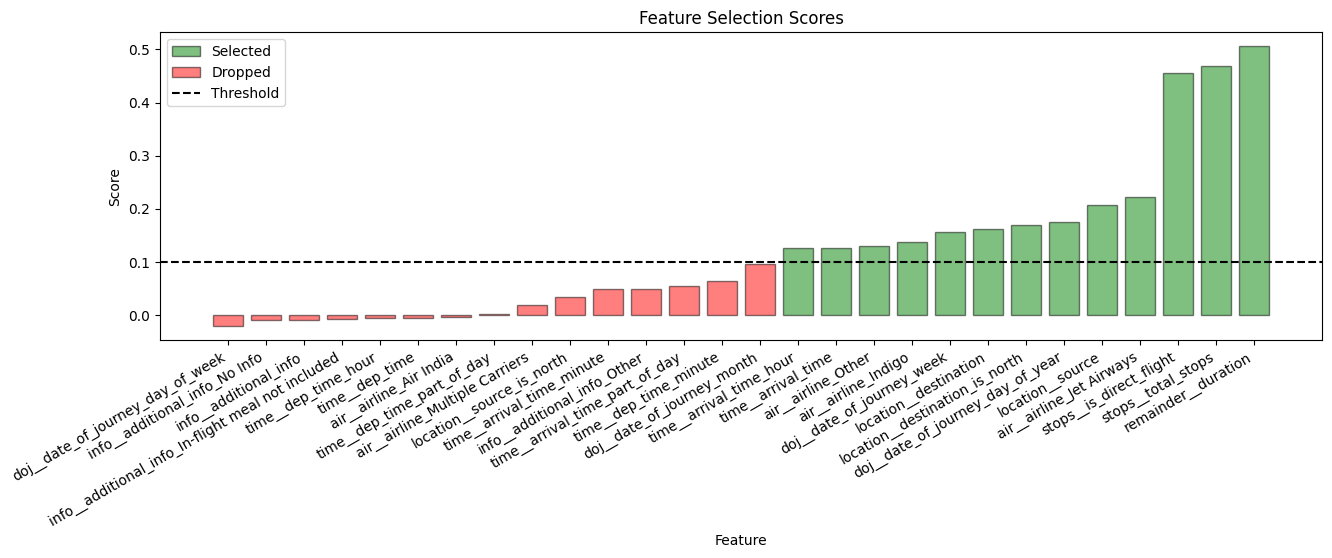

In [185]:
THRESHOLD = 0.1

selected_bar = None
dropped_bar = None
colors = ["red" if score < THRESHOLD else "green" for score in sorted_feat_imp.values()]


fig, ax = plt.subplots(figsize=(15, 4)) 

for i, (feature, score) in enumerate(sorted_feat_imp.items()):
	params = dict(
		x=i,
		height=score,
		edgecolor="black",
		alpha=0.5
	)
	
	if score < THRESHOLD:
		bar = ax.bar(
			color="red",
			**params
		)
		if not dropped_bar:
			dropped_bar = bar[0]
	else:
		bar = ax.bar(
			color="green",
			**params
		)
		if not selected_bar:
			selected_bar = bar[0]

thresh_line = ax.axhline(
	y=0.1,
	color="black",
	linestyle="--"
)

ax.set_xticks(
	ticks=range(len(sorted_feat_imp)),
	labels=list(sorted_feat_imp.keys()),
	rotation=30,
	ha="right"
)

ax.set(
	xlabel="Feature",
	ylabel="Score",
	title="Feature Selection Scores"
)

ax.legend(
	handles=[selected_bar, dropped_bar, thresh_line],
	labels=["Selected", "Dropped", "Threshold"],
	loc="upper left"
)

plt.show()


 - The dataset went upto 31 columns after Feature Engineering 
 - The Feature Selection algorithm selected 13 features out of that